# Getting started with DoWhy: A simple example

Source:
https://www.pywhy.org/dowhy/v0.8/example_notebooks/dowhy_simple_example.html

This is a quick introduction to the DoWhy causal inference library. We will load in a sample dataset and estimate the causal effect of a (pre-specified) treatment variable on a (pre-specified) outcome variable.

First, let us load all required packages.

In [1]:
import numpy as np
import pandas as pd

from dowhy import CausalModel
import dowhy.datasets

# Avoid printing data conversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Config dict to set the logging level
import logging
import logging.config
DEFAULT_LOGGING = {
    'version':1,
    'disable_existing_loggers': False,
    'loggers': {
        '':{
            'level':'WARN',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
logging.info("Getting started with DoWhy. Running notebook...")

Now, let us load a dataset. For simplicity, we simulate a dataset with linear relationships between common causes and treatment, and common causes and outcome.

Beta is the true causal effect.

In [2]:
data = dowhy.datasets.linear_dataset(beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_effect_modifiers=1,
    num_samples=5000,
    treatment_is_binary=True,
    stddev_treatment_noise=10,
    num_discrete_common_causes=1
)

df = data['df']
print(df.head())
print(data["dot_graph"])
print("\n")
print(data["gml_graph"])

         X0   Z0        Z1        W0  ...        W3  W4     v0          y
0  2.393200  0.0  0.590578 -1.064228  ...  0.512721   0  False  -2.828457
1  1.178624  1.0  0.719879 -0.672047  ...  0.860190   1   True  14.213753
2  1.001395  0.0  0.115297 -0.883733  ...  1.401448   1   True  16.071841
3  1.189908  1.0  0.915602  0.323495  ...  0.738425   1  False   0.720992
4 -1.477062  0.0  0.607728 -2.024942  ...  1.430640   2  False   5.566249

[5 rows x 10 columns]
digraph {v0->y;W0-> v0; W1-> v0; W2-> v0; W3-> v0; W4-> v0;Z0-> v0; Z1-> v0;W0-> y; W1-> y; W2-> y; W3-> y; W4-> y;X0-> y;}


graph[directed 1node[ id "y" label "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"] node[ id "W4" label "W4"]node[ id "Z0" label "Z0"] node[ id "Z1" label "Z1"]node[ id "v0" label "v0"]edge[source "v0" target "y"]edge[ source "W0" target "v0"] edge[ source "W1" target "v0"] edge[ source "W2" target "v0"] edge[ source "W3" target "v0"] edge[ sourc

Note that we are using a pandas dataframe to load the data. At present, DoWhy only support pandas dataframe as input

## Interface 1 (recommended): Input causal graph
We now input a causal graph in the GML graph format (recommended). You can also use the DOT format.

To create the causal graph for your dataset, you can use a tool like DAGitty that provides a GUI to construct the graph. You can export the graph string that it generates. The graph string is very close to the DOT format: just rename dag to digraph, remove newlines and add a semicolon after every line, to convert it to the DOT format and input to DoWhy.

In [9]:
# With graph
model = CausalModel(
    data=df,
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"]
)

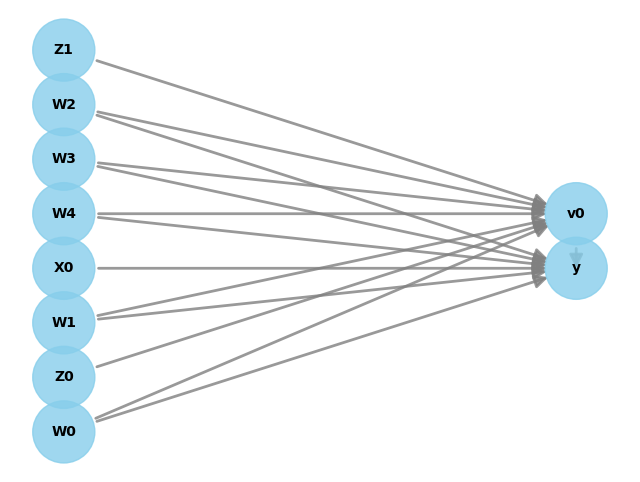

In [10]:
model.view_model()

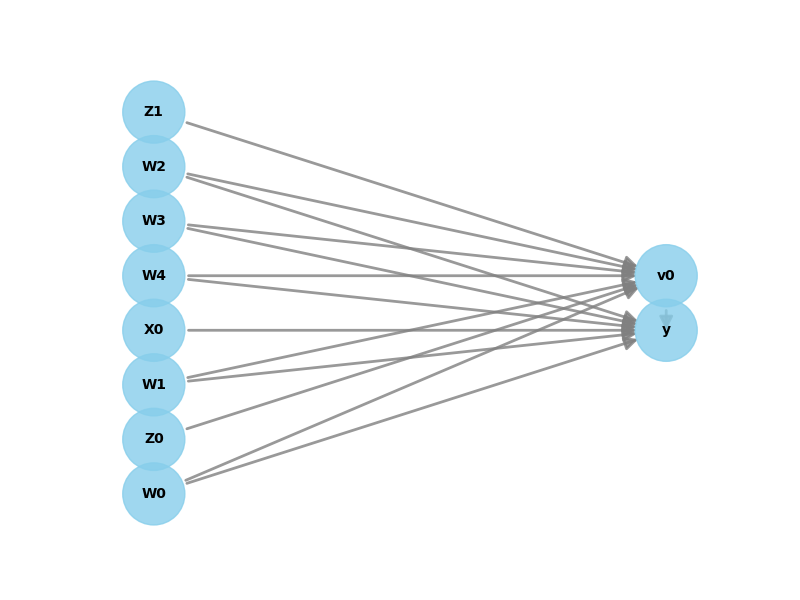

In [11]:
from IPython.display import Image, display
display(Image(filename='causal_model.png'))

The above causal graph shows the assumptions encoded in the causal model. We can now use this graph to first identify the causal effect (go from a causal estimand to a probability expression), and then estimate the causal effect.

#### From Copilot
Causal estimand is the formula which is forms of the causal relationship under causal assumption. A causal assumption is a belief or hypothesis about the cause-effect relationships in your data1. These assumptions are made explicit through a causal graph, which is a directed acyclic graph (DAG) where an edge X→Y implies that X causes Y.

For example, if you believe that studying hours (A) affects exam scores (Y), and both are influenced by intelligence (I), you might represent this as a causal graph with edges I→A, I→Y, and A→Y. This graph encodes your assumptions about the causal relationships in your data.

## DoWhy philosophy: Keep identification and estimation separate
Identification can be achieved without access to the data, acccesing only the graph. This results in an expression to be computed. This expression can then be evaluated using the available data in the estimation step. It is important to understand that these are orthogonal steps.

### Identification

In [12]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W1,W4,W3,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W4,W3,W2,U) = P(y|v0,W0,W1,W4,W3,W2)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Note the parameter flag proceed_when_unidentifiable. It needs to be set to True to convey the assumption that we are ignoring any unobserved confounding. The default behaviour is to prompt the user to double-check that the unobserved confounders can be ignored.

#### From Copilot
A confounder is a variable that influences both the treatment and the outcome. This can lead to a spurious association between the treatment and the outcome, making it seem like the treatment has an effect on the outcome when it actually doesn’t, or vice versa12.

For example, let’s say you’re studying the effect of exercise (treatment) on weight loss (outcome). Age could be a confounder here, because it can influence both exercise habits and weight. If you don’t control for age in your analysis, you might mistakenly attribute the effect of age on weight loss to exercise12.

### Estimation

In [13]:
causal_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W1,W4,W3,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W4,W3,W2,U) = P(y|v0,W0,W1,W4,W3,W2)

## Realized estimand
b: y~v0+W0+W1+W4+W3+W2
Target units: ate

## Estimate
Mean value: 10.780049368898865

Causal Estimate is 10.780049368898865


#### From Copilot
When you call model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_stratification"), you’re asking DoWhy to estimate the causal effect of the treatment on the outcome, as defined by the identified_estimand.

Here’s what’s happening step by step:

1. Estimand: The identified_estimand is the causal effect you’re interested in estimating. It’s an expression that represents the causal relationship under certain assumptions1.
2. Method: The method_name parameter specifies the estimation method to use. In this case, you’re using "backdoor.propensity_score_stratification", which is a method based on the propensity score2.
3. Propensity Score Stratification: This method first estimates the propensity score, which is the probability of receiving the treatment given the observed covariates. Then, it stratifies (or groups) the data into strata based on the propensity score. Within each stratum, the treatment and control groups are expected to be balanced on the observed covariates. The causal effect is then estimated within each stratum and averaged across strata to get the overall causal effect2.
4. Causal Effect: The output of this function is the estimated causal effect. This represents the expected change in the outcome when you intervene and change the treatment3. For example, if the treatment is binary (0 or 1), the causal effect represents the expected difference in the outcome between the treatment and control groups3.

So, in simple terms, you’re asking DoWhy to estimate how much the outcome would change if you change the treatment, using the propensity score stratification method

You can input additional parameters to the estimate_effect method. For instance, to estimate the effect on any subset of the units, you can specify the “target_units” parameter which can be a string (“ate”, “att”, or “atc”), lambda function that filters rows of the data frame, or a new dataframe on which to compute the effect. You can also specify “effect modifiers” to estimate heterogeneous effects across these variables. See 
```
help(CausalModel.estimate_effect)
```

In [14]:
help(CausalModel.estimate_effect)

Help on function estimate_effect in module dowhy.causal_model:

estimate_effect(self, identified_estimand, method_name=None, control_value=0, treatment_value=1, test_significance=None, evaluate_effect_strength=False, confidence_intervals=False, target_units='ate', effect_modifiers=None, fit_estimator=True, method_params=None)
    Estimate the identified causal effect.
    
    Currently requires an explicit method name to be specified. Method names follow the convention of identification method followed by the specific estimation method: "[backdoor/iv/frontdoor].estimation_method_name". For a list of supported methods, check out the :doc:`User Guide </user_guide/causal_tasks/estimating_causal_effects/index>`. Here are some examples.
    
        * Propensity Score Matching: "backdoor.propensity_score_matching"
        * Propensity Score Stratification: "backdoor.propensity_score_stratification"
        * Propensity Score-based Inverse Weighting: "backdoor.propensity_score_weighting"
  

In [15]:
# Causal effect on the control group (ATC)
causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W1,W4,W3,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W4,W3,W2,U) = P(y|v0,W0,W1,W4,W3,W2)

## Realized estimand
b: y~v0+W0+W1+W4+W3+W2
Target units: atc

## Estimate
Mean value: 10.706918180892007

Causal Estimate is 10.706918180892007


## Interface 2: Specify common causes and instruments

In [16]:
# Without graph
model = CausalModel(
    data=df,
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    common_causes=data["common_causes_names"],
    effect_modifiers=data["effect_modifier_names"]
)

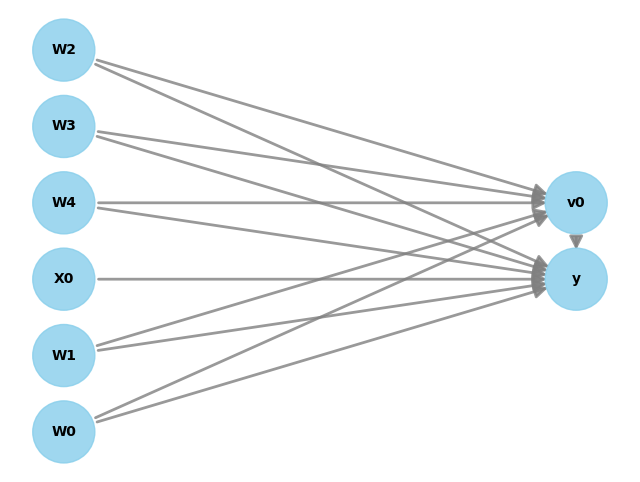

In [17]:
model.view_model()

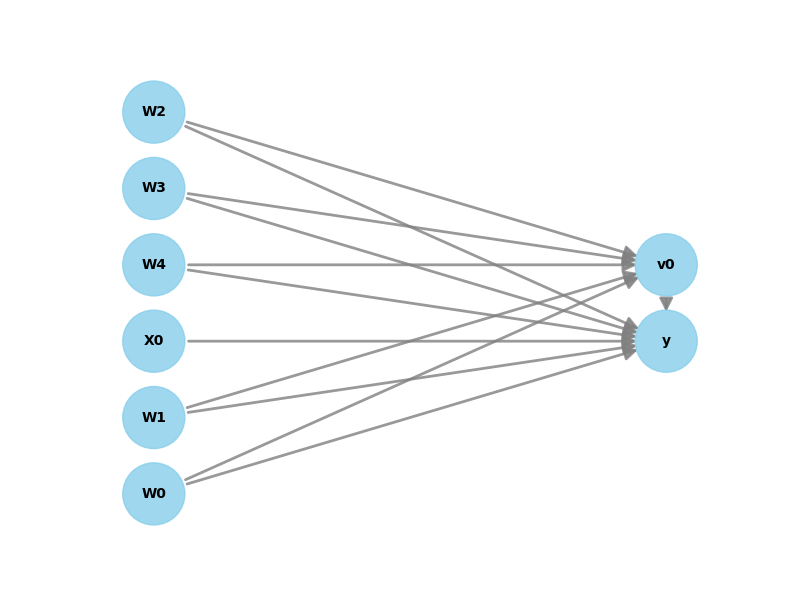

In [18]:
from IPython.display import Image, display
display(Image(filename='causal_model.png'))

We get the same causal graph. Now identification and estimation is done as before

In [19]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

In [20]:
estimate = model.estimate_effect(identified_estimand,
    method_name="backdoor.propensity_score_stratification")
print(estimate)
print("Causal Estimate is " + str(estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W1,W4,W3,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W4,W3,W2,U) = P(y|v0,W0,W1,W4,W3,W2)

## Realized estimand
b: y~v0+W0+W1+W4+W3+W2
Target units: ate

## Estimate
Mean value: 10.780049368898865

Causal Estimate is 10.780049368898865


#### From Copilot
The output you’re seeing is the result of a causal inference analysis using DoWhy. Here’s a simple interpretation:

1. Identified Estimand: This is the causal effect you’re interested in estimating. It’s represented as a mathematical expression, d(E[y|W0,W1,W4,W3,W2])/d[v0], which means the change in the expected value of y (the outcome) with respect to v0 (the treatment), while keeping W0, W1, W4, W3, W2 (the confounders) constant.

2. Estimand Assumption: This is the assumption under which the causal effect is identified. The “Unconfoundedness” assumption means that there are no hidden variables that affect both the treatment (v0) and the outcome (y).

3. Realized Estimand: This is the actual model used for estimationb: y~v0+W0+W1+W4+W3+W2 means that y is modeled as a function of v0 and the confounders W0, W1, W4, W3, W2.

4. Target Units: This refers to the population for which the causal effect is estimatedate stands for Average Treatment Effect, which means the effect is averaged over all units in the data.

5. Estimate: This is the estimated causal effect. A mean value of 10.780049368898865 means that, on average, a unit increase in v0 is associated with an approximately 10.78 unit increase in y, while keeping the confounders constant.

Here’s a simple example: Let’s say v0 represents hours of study, y represents exam scores, and W0, W1, W4, W3, W2 represent confounding factors like student’s intelligence, health, quality of teaching, etc. The causal estimate of 10.78 means that, on average, an additional hour of study is associated with an increase of 10.78 points in the exam score, assuming all other factors are held constant.

The reason confounding variables are important is because they can create a spurious association between the treatment and the outcome.

Let’s consider an example. Suppose we’re studying the effect of exercise (v0) on weight loss (y). Age (W) could be a confounder here. Here’s why:

Older people might exercise less (W affects v0).
Older people might also have slower metabolism and thus lose weight more slowly (W affects y).
If we don’t control for age, we might see a correlation between exercise and weight loss. But this correlation is not entirely due to exercise; part of it is due to age. If we mistakenly attribute the effect of age to exercise, we’ll overestimate the effect of exercise on weight loss.

By controlling for confounders (holding them constant), we can isolate the effect of the treatment on the outcome. This gives us a more accurate estimate of the causal effect.

So, even though we’re interested in the effect of v0 on y, we need to take into account the confounding variables to ensure that the relationship we’re seeing is not due to some other factors.

## Refuting the estimate
Let us now look at ways of refuting the estimate obtained. Refutation methods provide tests that every correct estimator should pass. So if an estimator fails the refutation test (p-value is <0.05), then it means that there is some problem with the estimator.

Note that we cannot verify that the estimate is correct, but we can reject it if it violates certain expected behavior (this is analogous to scientific theories that can be falsified but not proven true). The below refutation tests are based on either 

1. **Invariant transformations**: changes in the data that should not change the estimate. Any estimator whose result varies significantly between the original data and the modified data fails the test;

    a. Random Common Cause \
    b. Data Subset
    
2. **Nullifying transformations**: after the data change, the causal true estimate is zero. Any estimator whose result varies significantly from zero on the new data fails the test.

    a. Placebo Treatment

### Adding a random common cause variable

In [21]:
res_random = model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:10.780049368898865
New effect:10.780049368898867
p value:1.0



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:10.780049368898865
New effect:0.036175899662742886
p value:0.8799999999999999



### Removing a random subset of the data

In [23]:
res_subset = model.refute_estimate(identified_estimand, estimate,method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

Refute: Use a subset of data
Estimated effect:10.780049368898865
New effect:10.650271988798911
p value:0.18



As you can see, the propensity score stratification estimator is reasonably robust to refutations. For reproducibility, you can add a parameter “random_seed” to any refutation method, as shown below.

In [24]:
res_subset=model.refute_estimate(identified_estimand, estimate, method_name="data_subset_refuter", subset_fraction=0.9, random_seed=1)
print(res_subset)

Refute: Use a subset of data
Estimated effect:10.780049368898865
New effect:10.652041021318643
p value:0.16



## Adding an unobserved common cause variable
This refutation does not return a p-value. Instead, it provides a sensitivity test on how quickly the estimate changes if the identifying assumptions (used in ```identify_effect```) are not valid. Specifically, it checks sensitivity to violation of the backdoor assumption: that all common causes are observed.

To do so, it creates a new dataset with an additional common cause between treatment and outcome. To capture the effect of the common cause, the method takes as input the strength of common cause’s effect on treatment and outcome. Based on these inputs on the common cause’s effects, it changes the treatment and outcome values and then reruns the estimator. The hope is that the new estimate does not change drastically with a small effect of the unobserved common cause, indicating a robustness to any unobserved confounding.

Another equivalent way of interpreting this procedure is to assume that there was already unobserved confounding present in the input data. The change in treatment and outcome values removes the effect of whatever unobserved common cause was present in the original data. Then rerunning the estimator on this modified data provides the correct identified estimate and we hope that the difference between the new estimate and the original estimate is not too high, for some bounded value of the unobserved common cause’s effect.

**Importance of domain knowledge**: This test requires domain knowledge to set plausible input values of the effect of unobserved confounding. We first show the result for a single value of confounder’s effect on treatment and outcome.

In [25]:
res_unobserved=model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:10.780049368898865
New effect:10.240360604745998



It is often more useful to inspect the trend as the effect of unobserved confounding is increased. For that, we can provide an array of hypothesized confounders’ effects. The output is the (min, max) range of the estimated effects under different unobserved confounding.

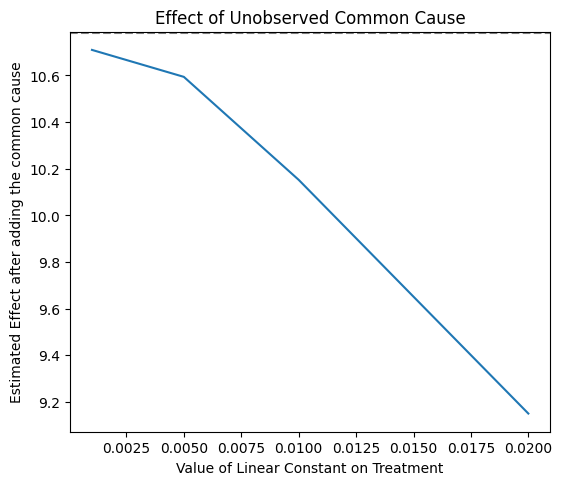

Refute: Add an Unobserved Common Cause
Estimated effect:10.780049368898865
New effect:(9.150688338914053, 10.709362098914537)



In [26]:
res_unobserved_range=model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=np.array([0.001, 0.005, 0.01, 0.02]), effect_strength_on_outcome=0.01)
print(res_unobserved_range)

The above plot shows how the estimate decreases as the hypothesized confounding on treatment increases. By domain knowledge, we may know the maximum plausible confounding effect on treatment. Since we see that the effect does not go beyond zero, we can safely conclude that the causal effect of treatment ```v0``` is positive.

We can also vary the confounding effect on both treatment and outcome. We obtain a heatmap.

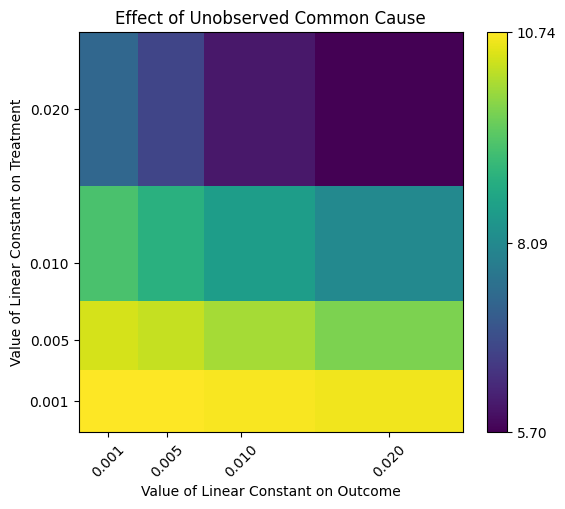

Refute: Add an Unobserved Common Cause
Estimated effect:10.780049368898865
New effect:(5.701065825303189, 10.743482694741498)



In [27]:
res_unobserved_range=model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause",
                                           confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                           effect_strength_on_treatment=[0.001, 0.005, 0.01, 0.02],
                                           effect_strength_on_outcome=[0.001, 0.005, 0.01,0.02])
print(res_unobserved_range)

**Automatically inferring effect strength parameters**. Finally, DoWhy supports automatic selection of the effect strength parameters. This is based on an assumption that the effect of the unobserved confounder on treatment or outcome cannot be stronger than that of any observed confounder. That is, we have collected data at least for the most relevant confounder. 

If that is the case, then we can bound the range of effect_strength_on_treatment and effect_strength_on_outcome by the effect strength of observed confounders. There is an additional optional parameter signifying whether the effect strength of unobserved confounder should be as high as the highest observed, or a fraction of it. You can set it using the optional effect_fraction_on_treatment and effect_fraction_on_outcome parameters. By default, these two parameters are 1.

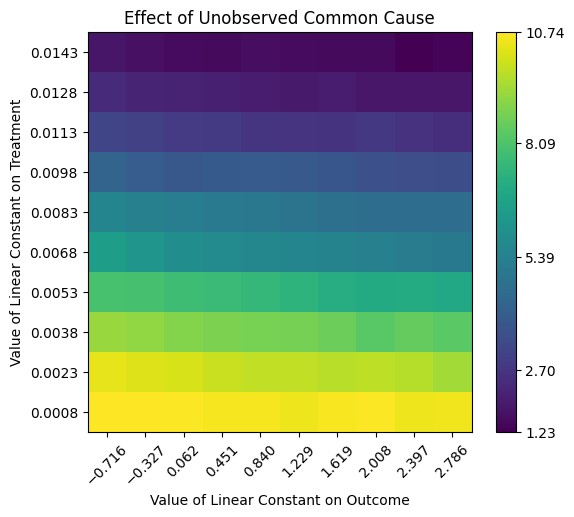

Refute: Add an Unobserved Common Cause
Estimated effect:10.780049368898865
New effect:(1.2276014927240897, 10.7391777871861)



In [28]:
res_unobserved_auto = model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause",
                                           confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear")
print(res_unobserved_auto)

**Conclusion**: Assuming that the unobserved confounder does not affect the treatment or outcome more strongly than any observed confounder, the causal effect can be concluded to be positive.